In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
#keras 사용
keras = tf.keras

In [2]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

## 데이터 다운로드

In [3]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cifar10',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
# (이미지, 레이블) 쌍으로 이루어져 있고 이미지는 3개 채널로 구성되며 레이블은 스칼라로 구성되어 있음
print(raw_train)
print(raw_validation)
print(raw_test) # 32 x 32 x 3 (채널)

<PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


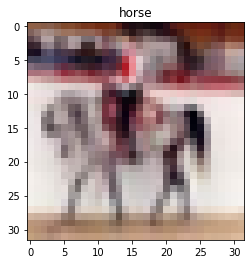

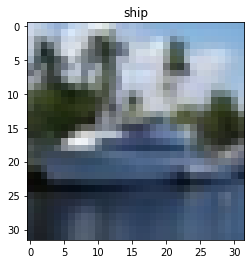

In [5]:
# 훈련용 데이터셋에서 처음 두개의 이미지 및 레이블을 보여줌
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

## 데이터 포맷
- `tf.image` 모듈을 사용해서 이미지를 포맷
- 이미지를 고정된 입력 크기로 조정하고 입력 채널의 크기를 [-1, 1] 범위로 조정

In [7]:
IMG_SIZE = 224 # 모든 이미지는 224x224으로 크기가 조정됩니다 -> 32 x 32 를 바꿈

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1

  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [8]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [9]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [12]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE) # random 하고 batch

In [14]:
for image_batch, label_batch in train_batches.take(1):
   pass
# 32 개
image_batch.shape

TensorShape([32, 224, 224, 3])

## 사용할 모델 가져오기

In [15]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

87924736/87910968 [==============================] - 0s 0us/step


In [16]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [17]:
# 기본 모델 아키텍처를 살펴봅니다.
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # global
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [20]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  keras.layers.Dense(1028, activation='relu'),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(10, activation='softmax')
]) # 4개의 선형모델 -> 노드가 작아지도록 설정, 카테고리 갯수인 10개로 설정

In [21]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])# 정확도 기준으로 정함

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_4 (Dense)             (None, 1028)              2106372   
                                                                 
 dense_5 (Dense)             (None, 512)               526848    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 10)                2570      
                                                      

In [23]:
initial_epochs = 10
validation_steps=20

In [24]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
1250/1250 [==============================] - 360s 279ms/step - loss: 0.3815 - accuracy: 0.8780 - val_loss: 0.1889 - val_accuracy: 0.9400
Epoch 2/10
1250/1250 [==============================] - 335s 268ms/step - loss: 0.1553 - accuracy: 0.9496 - val_loss: 0.1662 - val_accuracy: 0.9476
Epoch 3/10
1250/1250 [==============================] - 336s 268ms/step - loss: 0.1092 - accuracy: 0.9652 - val_loss: 0.2091 - val_accuracy: 0.9362
Epoch 4/10
1250/1250 [==============================] - 334s 267ms/step - loss: 0.0901 - accuracy: 0.9714 - val_loss: 0.2704 - val_accuracy: 0.9272
Epoch 5/10
1250/1250 [==============================] - 334s 267ms/step - loss: 0.0739 - accuracy: 0.9763 - val_loss: 0.2070 - val_accuracy: 0.9406
Epoch 6/10
1250/1250 [==============================] - 334s 267ms/step - loss: 0.0676 - accuracy: 0.9787 - val_loss: 0.2048 - val_accuracy: 0.9442
Epoch 7/10
1250/1250 [==============================] - 334s 267ms/step - loss: 0.0591 - accuracy: 0.9815 - val_

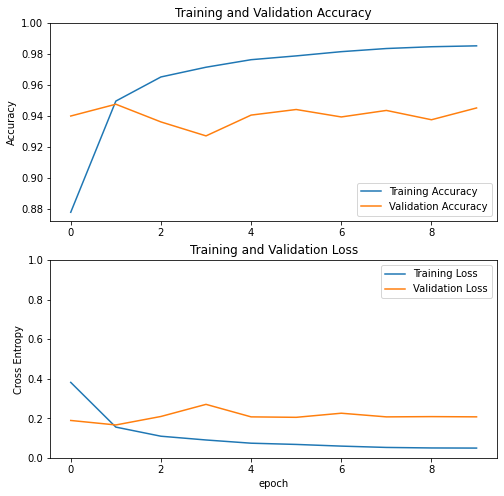

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
loss, acc = model.evaluate(test_batches, batch_size=64)
print('loss from test data', loss)
print('accuracy from test data ', acc)

157/157 [==============================] - 12s 73ms/step - loss: 0.1755 - accuracy: 0.9492
loss from test data 0.1755172610282898
accuracy from test data  0.9491999745368958
